# Параллельный алгоритм сегментации серого изображения расширением регионов (Region Growing Grayscale Image Segmentation)

### Сайбель Т. А. 423 группа, 30.09.2021

## Watershed-based algorithm
#### Input: исходное изображение
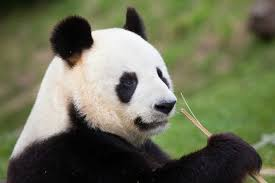

#### Output: изображение, состоящее из сегментов
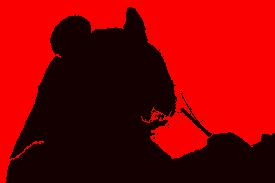

### Паралеллизация
Основной процесс считывает изображение (изображение хранится в np.array), 
рассылает соответсвующие части изображения по процессам, получает кластер, хранящий результат, 
и сохраняет результат в outputfile+'.jpeg'
### Результаты
#### Характеристики системы:
       Ubuntu 21.04
       3.6GHz AMD Ryzen 5 3600 6-core processor
       64 Гб 3200 MHz DDR4
       
Построение графика через google таблицы

#### Время выполнения для изображения размером 183х275:
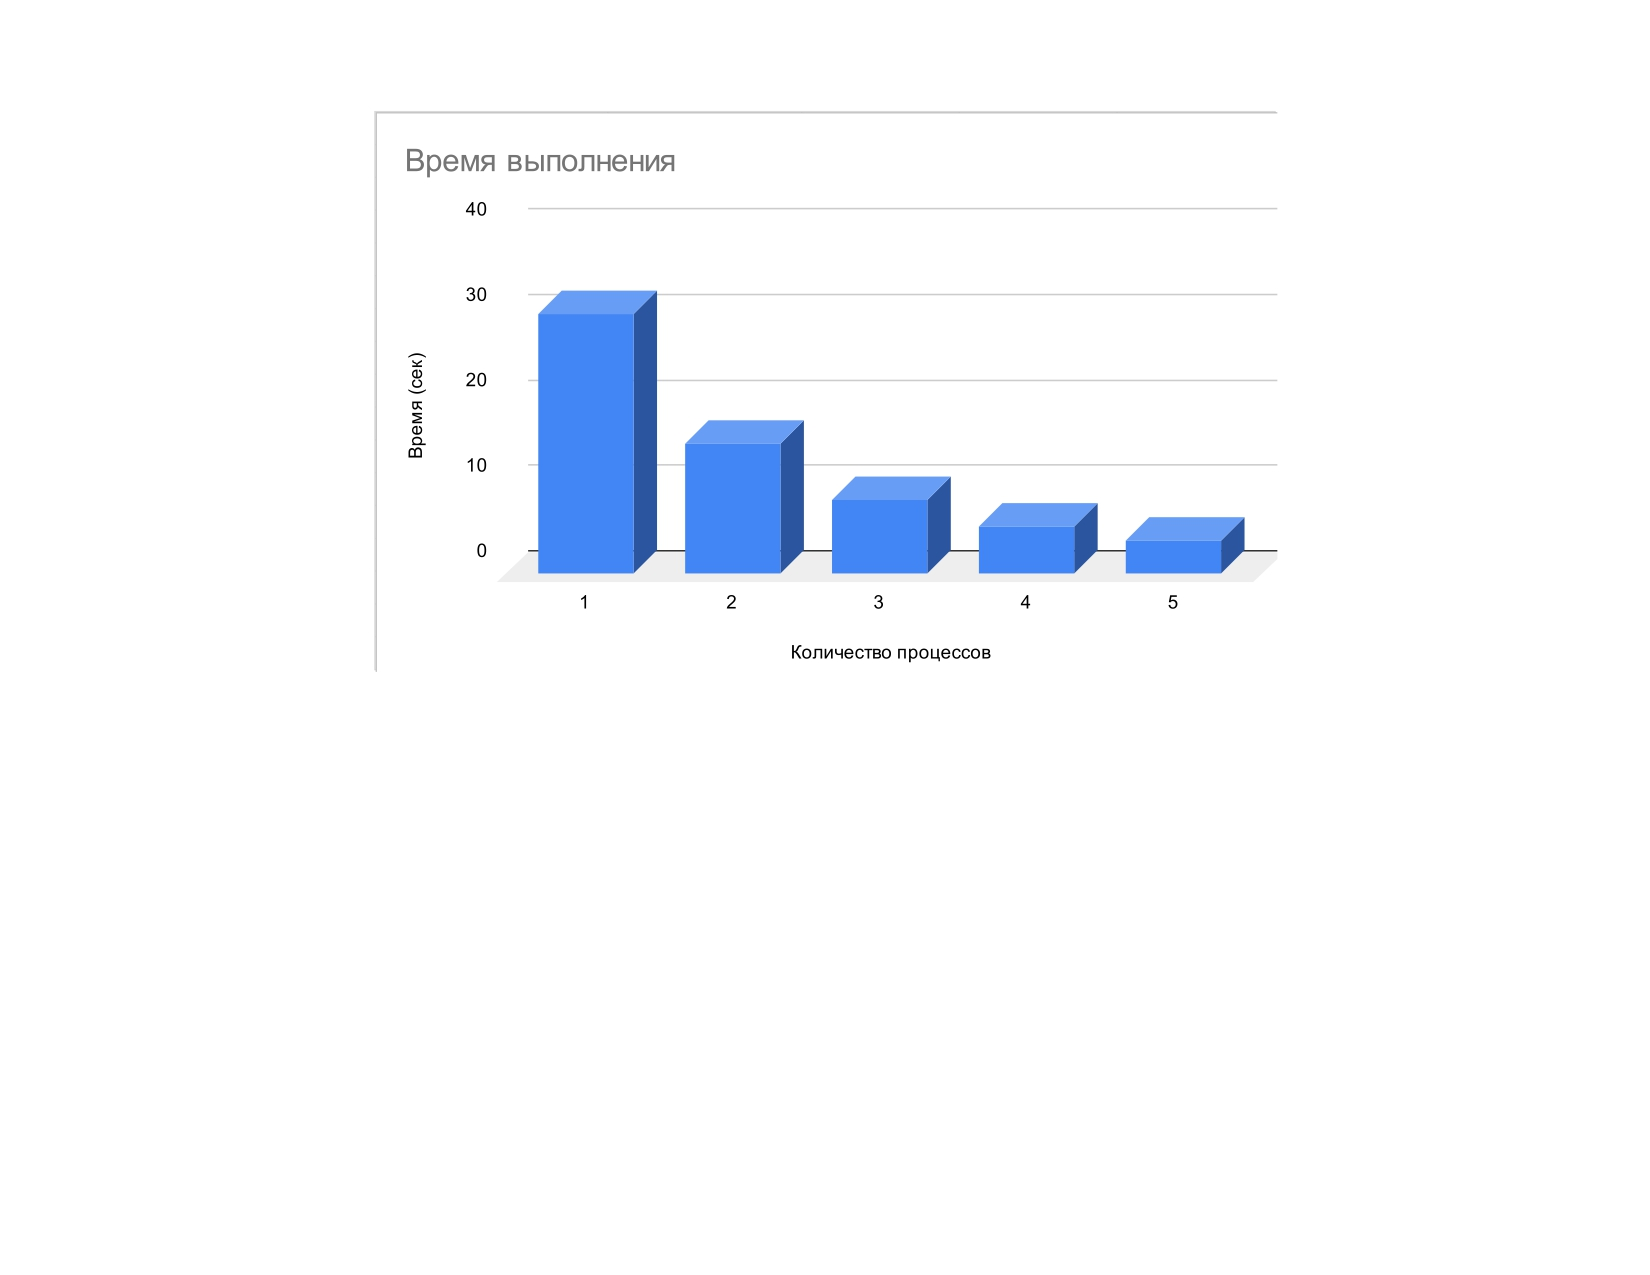

## Код:

In [1]:
import numpy as np
from mpi4py import MPI
from PIL import Image

##### Исходный файл и файл с результатом

In [2]:
outputfile = 'images/res'
inputfile = 'images/input.jpg'

##### Stack (необходим для основной функции)

In [3]:
class Stack:
    def __init__(self):
        self.items = []

    def isEmpty(self):
        return self.items == []

    def put(self, item):
        self.items.append(item)

    def pop(self):
        return self.items.pop()

    def size(self):
        return len(self.items)

    def isInside(self, item):
        return item in self.items

    def getLastN(self, n):
        if self.size() < n:
            return self.items
        else:
            return self.items[-n:]

    def __str__(self):
        return self.items

##### Основная функция

In [4]:
def regionGrowing(mat, epsilon, meancount, start_point):
    ST = Stack()

    s = []
    x = start_point[0]
    y = start_point[1]

    ST.put((x, y))

    while not ST.isEmpty():
        temp = ST.getLastN(meancount)
        sum = 0
        for i in temp:
            xt = i[0]
            yt = i[1]
            sum += mat[xt][yt]

        mean = float(sum) / len(temp)

        t = ST.pop()
        x = t[0]
        y = t[1]

        if t not in s:
            s.append(t)

        # Рассматривается 8-связная область
        if x < len(mat) - 1 and abs(mat[x + 1][y] - mean) <= epsilon:
            if not ST.isInside((x + 1, y)) and not (x + 1, y) in s:
                ST.put((x + 1, y))

        if x < len(mat) - 1 and y < len(mat[0]) - 1 and abs(mat[x + 1][y + 1] - mean) <= epsilon:
            if not ST.isInside((x + 1, y + 1)) and not (x + 1, y + 1) in s:
                ST.put((x + 1, y + 1))

        if y < len(mat[0]) - 1 and abs(mat[x][y + 1] - mean) <= epsilon:
            if not ST.isInside((x, y + 1)) and not (x, y + 1) in s:
                ST.put((x, y + 1))

        if x > 0 and y < len(mat[0]) - 1 and abs(mat[x - 1][y + 1] - mean) <= epsilon:
            if not ST.isInside((x - 1, y + 1)) and not (x - 1, y + 1) in s:
                ST.put((x - 1, y + 1))

        if x > 0 and abs(mat[x - 1][y] - mean) <= epsilon:
            if not ST.isInside((x - 1, y)) and not (x - 1, y) in s:
                ST.put((x - 1, y))

        if x > 0 and y > 0 and abs(mat[x - 1][y - 1] - mean) <= epsilon:
            if not ST.isInside((x - 1, y - 1)) and not (x - 1, y - 1) in s:
                ST.put((x - 1, y - 1))

        if y > 0 and abs(mat[x][y - 1] - mean) <= epsilon:
            if not ST.isInside((x, y - 1)) and not (x, y - 1) in s:
                ST.put((x, y - 1))

        if x < len(mat) - 1 and y > 0 and abs(mat[x + 1][y - 1] - mean) <= epsilon:
            if not ST.isInside((x + 1, y - 1)) and not (x + 1, y - 1) in s:
                ST.put((x + 1, y - 1))

    return s

##### Функция, сохраняющая результат

In [5]:
def saveImage(image, s):
    image.load()
    putpixel = image.im.putpixel

    for i in range(image.size[1]):
        for j in range(image.size[0]):
            if (i, j) not in s:
                putpixel((j, i), 20)
            else:
                putpixel((j, i), 250)

    image.thumbnail((image.size[0], image.size[1]), Image.ANTIALIAS)
    image.save(outputfile + '.jpeg', 'JPEG')

In [6]:
if __name__ == '__main__':
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    # Время выполнения
    t = 0.0

    if rank == 0:

        image = Image.open(inputfile)
        mat = np.array(image.convert("L"), 'f')

        # Кластер, хранящий результат
        s = []

        if size != 1:
            for i in range(1, size):
                startPos = int(mat.shape[0] / (size - 1)) * (i - 1)
                endPos = mat.shape[0] if i == size - 1 else int(mat.shape[0] / (size - 1)) * i
                tmp = np.array(mat[startPos:endPos])
                comm.send(tmp, dest=i)

            for i in range(1, size):
                got = comm.recv(source=i)
                s.append(got)
                gotTime = comm.recv(source=i, tag=11)
                if gotTime > t:
                    t = gotTime

        else:
            t = MPI.Wtime()
            s = regionGrowing(mat, 20, 24, (0, 0))
            t = MPI.Wtime() - t

        print('Time for {} processes: {} sec'.format(size, t))

        saveImage(image, s)
    else:
        mat = comm.recv(source=0)
        t = MPI.Wtime()
        s = regionGrowing(mat, 20, 24, (0, 0))
        t = MPI.Wtime() - t
        comm.send(s, dest=0)
        comm.send(t, dest=0, tag=11)

Time for 1 processes: 30.374818086624146 sec
